In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem, t, ttest_1samp

def load_metrics_to_dataframe(output_dir):
    """
    Load all JSON metrics from the specified directory and organize them into a Pandas DataFrame.

    Args:
        output_dir (str): Directory containing JSON files.

    Returns:
        pd.DataFrame: DataFrame containing all metrics, sorted by combinations.
    """
    metrics_list = []

    # Iterate over all JSON files in the directory
    for file_name in os.listdir(output_dir):
        if file_name.endswith(".json"):  # Only process JSON files
            file_path = os.path.join(output_dir, file_name)
            with open(file_path, "r") as infile:
                try:
                    # Load the JSON data
                    data = json.load(infile)
                    for combo, metrics in data.items():
                        metrics_list.append({
                            "Bootstrap": file_name,
                            "Combination": combo,
                            **metrics
                        })
                except json.JSONDecodeError as e:
                    print(f"Error decoding {file_path}: {e}")

    # Convert the list of metrics to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Sort the DataFrame by combination
    metrics_df = metrics_df.sort_values(by="Combination").reset_index(drop=True)

    print(f"Loaded metrics from {len(metrics_df)} combinations.")
    return metrics_df

def separate_event_metrics(df):
    """
    Separate and expand metrics for Event_1 and Event_2 into distinct columns.

    Args:
        df (pd.DataFrame): Original DataFrame containing nested metrics for events.

    Returns:
        pd.DataFrame: Updated DataFrame with separate columns for Event_1 and Event_2 metrics.
    """
    # Initialize lists to store separated data
    event_1_data = []
    event_2_data = []

    for idx, row in df.iterrows():
        # Extract Nam-Dagostino results for Event_1 and Event_2
        nam_dagostino_event_1 = [item for item in row["nam_dagostino_results"] if item["Event"] == 1]
        nam_dagostino_event_2 = [item for item in row["nam_dagostino_results"] if item["Event"] == 2]

        # Extract nested metrics
        event_1_row = {
            "Bootstrap": row["Bootstrap"],
            "Combination": row["Combination"],
            "Concordance_Index": row["concordance_indices"]["Event_1"],
            "Integrated_Brier_Score": row["integrated_brier_scores"]["Event_1"],
            "Neg_Log_Likelihood": row["neg_log_likelihoods"]["Event_1"],
            "Nam_Dagostino": nam_dagostino_event_1
        }
        event_2_row = {
            "Bootstrap": row["Bootstrap"],
            "Combination": row["Combination"],
            "Concordance_Index": row["concordance_indices"]["Event_2"],
            "Integrated_Brier_Score": row["integrated_brier_scores"]["Event_2"],
            "Neg_Log_Likelihood": row["neg_log_likelihoods"]["Event_2"],
            "Nam_Dagostino": nam_dagostino_event_2
        }

        # Append separated rows
        event_1_data.append(event_1_row)
        event_2_data.append(event_2_row)

    # Create separate DataFrames for Event_1 and Event_2
    event_1_df = pd.DataFrame(event_1_data)
    event_1_df["Event"] = "Event_1"

    event_2_df = pd.DataFrame(event_2_data)
    event_2_df["Event"] = "Event_2"

    # Combine into a single DataFrame
    combined_df = pd.concat([event_1_df, event_2_df], axis=0).reset_index(drop=True)

    return combined_df

def sort_metrics_by_combination_length(df):
    """
    Sort metrics for Event_1 and Event_2 by the length of the combination (as tuples).

    Args:
        df (pd.DataFrame): Input DataFrame containing metrics with Combination as tuples.

    Returns:
        pd.DataFrame: Sorted DataFrame with an additional "Combination_Length" column.
    """
    # Ensure the Combination column contains tuples
    assert all(isinstance(combo, tuple) for combo in df["Combination"]), "Combination column must contain tuples."

    # Add a column for the length of combinations
    df["Combination_Length"] = df["Combination"].apply(len)

    # Sort by Combination_Length and Combination (optional for consistency)
    sorted_df = df.sort_values(by=["Combination_Length", "Combination"], ascending=True).reset_index(drop=True)

    return sorted_df

def calculate_statistics_per_combination_length(df):
    """
    Calculate the mean, 95% CI, and p-value for concordance index, integrated brier score, and negative log likelihood
    for Event_1 and Event_2, grouped by combination length.

    Args:
        df (pd.DataFrame): Input DataFrame containing metrics and combination lengths.

    Returns:
        pd.DataFrame: Summary statistics for each combination length and event.
    """
    results = []

    # Group by Combination_Length and Event
    grouped = df.groupby(["Combination_Length", "Event"])

    for (comb_length, event), group in grouped:
        stats = {
            "Combination_Length": comb_length,
            "Event": event,
        }

        # Calculate statistics for each metric
        for metric in ["Concordance_Index", "Integrated_Brier_Score", "Neg_Log_Likelihood"]:
            values = group[metric].values
            mean = np.mean(values)
            std_err = sem(values)  # Standard error
            ci_low, ci_high = t.interval(0.95, len(values) - 1, loc=mean, scale=std_err)  # 95% CI
            
            # Perform a one-sample t-test against 0.5 as an example (adjust as needed)
            t_stat, p_value = ttest_1samp(values, 0.5)
            
            stats[f"{metric}_Mean"] = mean
            stats[f"{metric}_CI_Low"] = ci_low
            stats[f"{metric}_CI_High"] = ci_high
            stats[f"{metric}_P_Value"] = p_value

        results.append(stats)

    return pd.DataFrame(results)

def plot_metric_vs_combination_length(df, metric_name, event_col="Event"):
    """
    Generalized function to plot a specified metric against combination length.
    
    Args:
        df (pd.DataFrame): DataFrame containing metrics for combinations of models.
        metric_name (str): The base name of the metric to plot (e.g., "Concordance_Index").
        event_col (str): The column representing the event type (default is "Event").
    
    Returns:
        None: Displays the plot.
    """
    # Ensure the metric columns exist
    metric_mean_col = f"{metric_name}_Mean"
    metric_ci_low_col = f"{metric_name}_CI_Low"
    metric_ci_high_col = f"{metric_name}_CI_High"
    
    if not all(col in df.columns for col in [metric_mean_col, metric_ci_low_col, metric_ci_high_col, event_col]):
        raise ValueError(f"One or more required columns for '{metric_name}' are missing in the DataFrame.")
    
    # Plot for each event
    unique_events = df[event_col].unique()
    plt.figure(figsize=(10, 6))
    
    for event in unique_events:
        event_data = df[df[event_col] == event]
        combination_lengths = event_data["Combination_Length"]
        metric_means = event_data[metric_mean_col]
        ci_low = event_data[metric_ci_low_col]
        ci_high = event_data[metric_ci_high_col]
        
        # Plot mean and confidence interval
        plt.plot(combination_lengths, metric_means, label=f"{metric_name} (Event {event})")
        plt.fill_between(combination_lengths, ci_low, ci_high, alpha=0.2, label=f"95% CI (Event {event})")
    
    # Customize the plot
    plt.title(f"{metric_name} vs. Number of Model Predictions Ensembled")
    plt.xlabel("Number of Model Predictions Ensembled")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(False)
    plt.show()

def reshape_brier_scores(metrics_df):
    """
    Reshape the Brier scores into a flat structure with columns like 'event_1_year_0', 'event_2_year_1', etc.

    Args:
        metrics_df (pd.DataFrame): The input DataFrame containing metrics, including 'brier_series'.

    Returns:
        pd.DataFrame: A DataFrame where Brier scores are flattened into specific columns for each event and year.
    """
    # Ensure the Combination column contains tuples
    assert all(isinstance(combo, tuple) for combo in metrics_df["Combination"]), "Combination column must contain tuples."

    # Add a column for the length of combinations
    metrics_df["Combination_Length"] = metrics_df["Combination"].apply(len)

    reshaped_data = []

    for idx, row in metrics_df.iterrows():
        # Start with base row data
        reshaped_row = {
            "Bootstrap": row["Bootstrap"],
            "Combination": row["Combination"],
            "Combination_Length": row["Combination_Length"]
        }

        # Flatten Brier scores
        brier_series = row["brier_series"]
        for event, scores in brier_series.items():  # Iterate over Event_1 and Event_2
            for year, score in enumerate(scores):  # Iterate over years (0, 1, 2, 3, 4, 5)
                column_name = f"{event.lower()}_year_{year}"
                reshaped_row[column_name] = score

        reshaped_data.append(reshaped_row)

    return pd.DataFrame(reshaped_data)

def calculate_brier_statistics(reshaped_brier_df):
    """
    Calculate the mean, 95% CI, and p-value for Brier scores for each combination length and time point.

    Args:
        reshaped_brier_df (pd.DataFrame): DataFrame with reshaped Brier scores.

    Returns:
        pd.DataFrame: DataFrame with aggregated statistics for each combination length and time point.
    """
    aggregated_data = []

    for combination_length in reshaped_brier_df["Combination_Length"].unique():
        subset = reshaped_brier_df[reshaped_brier_df["Combination_Length"] == combination_length]

        for event in ["event_1", "event_2"]:
            for year in range(6):  # Assuming 6 years
                column_name = f"{event}_year_{year}"
                values = subset[column_name].dropna()

                if len(values) > 1:
                    mean = values.mean()
                    std_err = values.std(ddof=1) / np.sqrt(len(values))
                    ci_low, ci_high = t.interval(0.95, len(values) - 1, loc=mean, scale=std_err)
                    t_stat, p_value = ttest_1samp(values, 0.0)
                else:
                    mean, ci_low, ci_high, p_value = [np.nan] * 4

                aggregated_data.append({
                    "Combination_Length": combination_length,
                    "Event": event,
                    "Time_Point": year,
                    "Brier_Mean": mean,
                    "Brier_CI_Low": ci_low,
                    "Brier_CI_High": ci_high,
                    "P_Value": p_value
                })

    return pd.DataFrame(aggregated_data)

def plot_brier_scores(brier_stats_df):
    """
    Plot the Brier scores for different combination lengths and events.

    Args:
        brier_stats_df (pd.DataFrame): DataFrame with Brier score statistics.
    """
    for event in ["event_1", "event_2"]:
        event_data = brier_stats_df[brier_stats_df["Event"] == event]
        plt.figure(figsize=(10, 6))
        for combination_length in event_data["Combination_Length"].unique():
            subset = event_data[event_data["Combination_Length"] == combination_length]
            plt.plot(
                subset["Time_Point"],
                subset["Brier_Mean"],
                label=f"Combination Length {combination_length}"
            )
            plt.fill_between(
                subset["Time_Point"],
                subset["Brier_CI_Low"],
                subset["Brier_CI_High"],
                alpha=0.2
            )

        plt.title(f"Brier Scores for {event.replace('_', ' ').title()}")
        plt.xlabel("Time Point")
        plt.ylabel("Brier Score")
        plt.legend()
        plt.grid(True)
        plt.show()


In [4]:
output_dir = "/mnt/d/PYDataScience/g3_regress/data/results/avg_ensemble"

# Load metrics into a DataFrame
metrics_df = load_metrics_to_dataframe(output_dir)

separated_metrics_df = separate_event_metrics(metrics_df)

# Ensure the Combination column contains tuples (if not already)
separated_metrics_df["Combination"] = separated_metrics_df["Combination"].apply(eval)  # Convert string to tuple, if needed

# Sort the metrics by combination length
sorted_metrics_df = sort_metrics_by_combination_length(separated_metrics_df)

# Calculate statistics
summary_stats_df = calculate_statistics_per_combination_length(sorted_metrics_df)


Loaded metrics from 34778 combinations.


,Combination_Length,Event,Concordance_Index_Mean,Concordance_Index_CI_Low,Concordance_Index_CI_High,Concordance_Index_P_Value,Integrated_Brier_Score_Mean,Integrated_Brier_Score_CI_Low,Integrated_Brier_Score_CI_High,Integrated_Brier_Score_P_Value,Neg_Log_Likelihood_Mean,Neg_Log_Likelihood_CI_Low,Neg_Log_Likelihood_CI_High,Neg_Log_Likelihood_P_Value
0,1,Event_1,0.883165,0.873598,0.892732,6.802493e-319,0.058553,0.057168,0.059938,0.0,0.192601,0.188913,0.196289,0.000000e+00
1,1,Event_2,0.627738,0.617776,0.637700,3.986277e-96,0.113506,0.111009,0.116002,0.0,0.416491,0.399952,0.433029,1.425700e-21
2,2,Event_1,0.938495,0.934991,0.941999,0.000000e+00,0.046275,0.045773,0.046776,0.0,0.163081,0.161694,0.164469,0.000000e+00
3,2,Event_2,0.676064,0.671544,0.680585,0.000000e+00,0.100900,0.100051,0.101749,0.0,0.329374,0.326713,0.332034,0.000000e+00
4,3,Event_1,0.965240,0.964003,0.966477,0.000000e+00,0.042182,0.041936,0.042428,0.0,0.154551,0.153868,0.155234,0.000000e+00


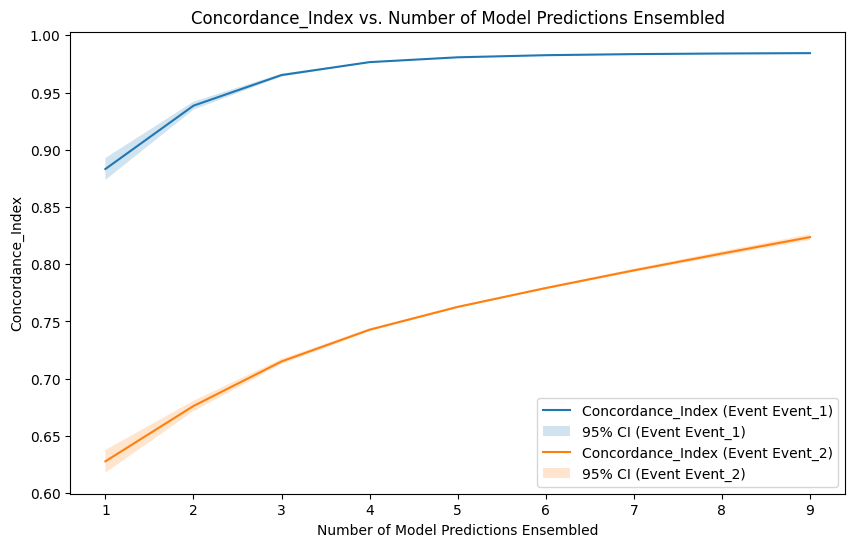

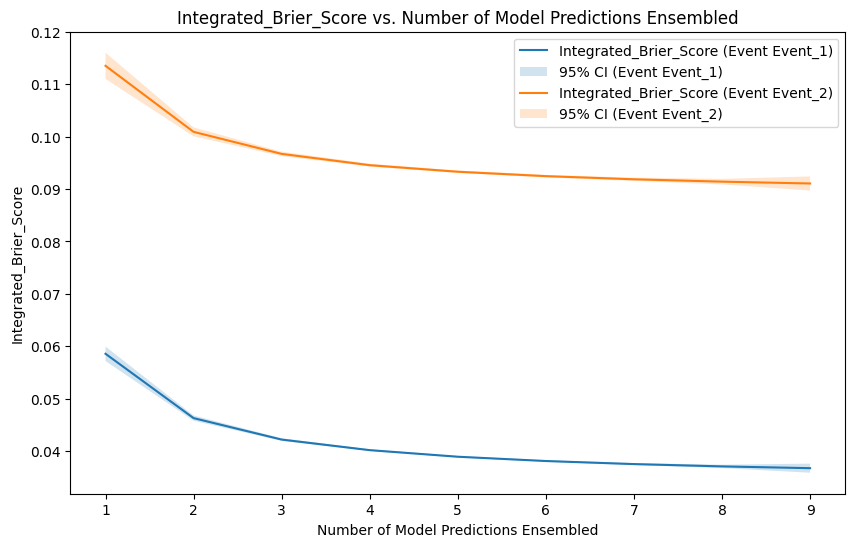

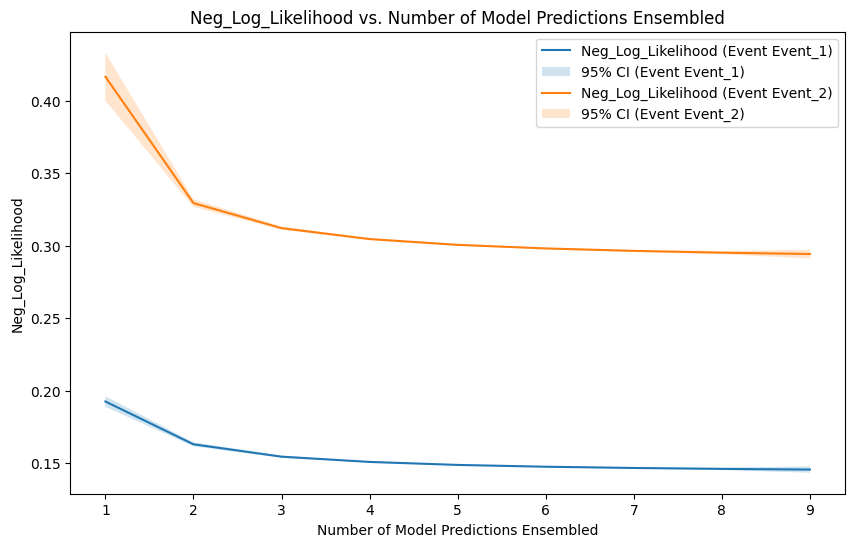

In [44]:

# Display the results
display(summary_stats_df.head())

# Call the updated plotting function with the same DataFrame
plot_metric_vs_combination_length(summary_stats_df, metric_name="Concordance_Index")
plot_metric_vs_combination_length(summary_stats_df, metric_name="Integrated_Brier_Score")
plot_metric_vs_combination_length(summary_stats_df, metric_name="Neg_Log_Likelihood")

In [6]:
metrics_df['Combination'] = metrics_df['Combination'].apply(eval)
# Reshape the Brier scores
reshaped_brier_df = reshape_brier_scores(metrics_df)

# Display the reshaped DataFrame
print(reshaped_brier_df.head())


                                           Bootstrap  \
0  bootstrap_28_combo_deephit_ann_NearMiss_deephi...   
1  bootstrap_34_combo_deephit_ann_NearMiss_deephi...   
2  bootstrap_59_combo_deephit_ann_NearMiss_deephi...   
3  bootstrap_19_combo_deephit_ann_NearMiss_deephi...   
4  bootstrap_31_combo_deephit_ann_NearMiss_deephi...   

                                     Combination  Combination_Length  \
0  (deephit_ann_NearMiss, deephit_lstm_NearMiss)                   2   
1  (deephit_ann_NearMiss, deephit_lstm_NearMiss)                   2   
2  (deephit_ann_NearMiss, deephit_lstm_NearMiss)                   2   
3  (deephit_ann_NearMiss, deephit_lstm_NearMiss)                   2   
4  (deephit_ann_NearMiss, deephit_lstm_NearMiss)                   2   

   event_1_year_0  event_1_year_1  event_1_year_2  event_1_year_3  \
0    1.761093e-07        0.004159        0.011120        0.026530   
1    1.734112e-07        0.004134        0.010566        0.022927   
2    1.785073e-07      

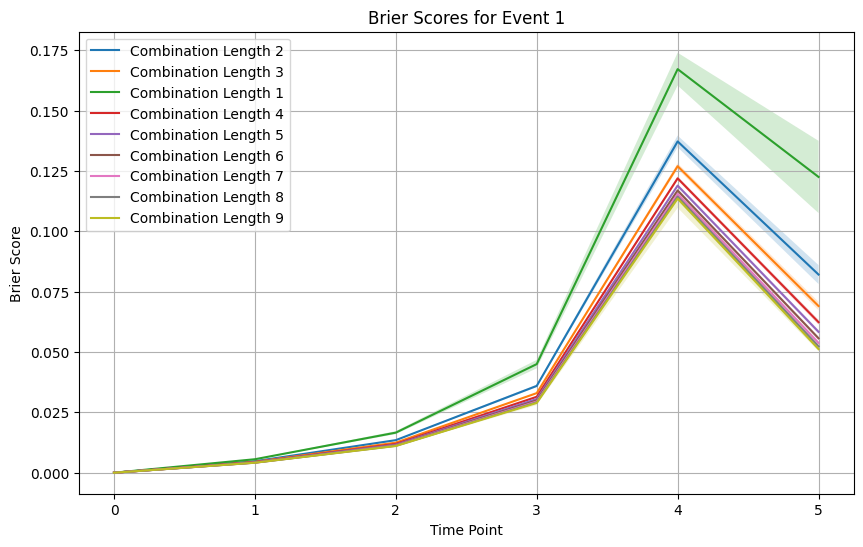

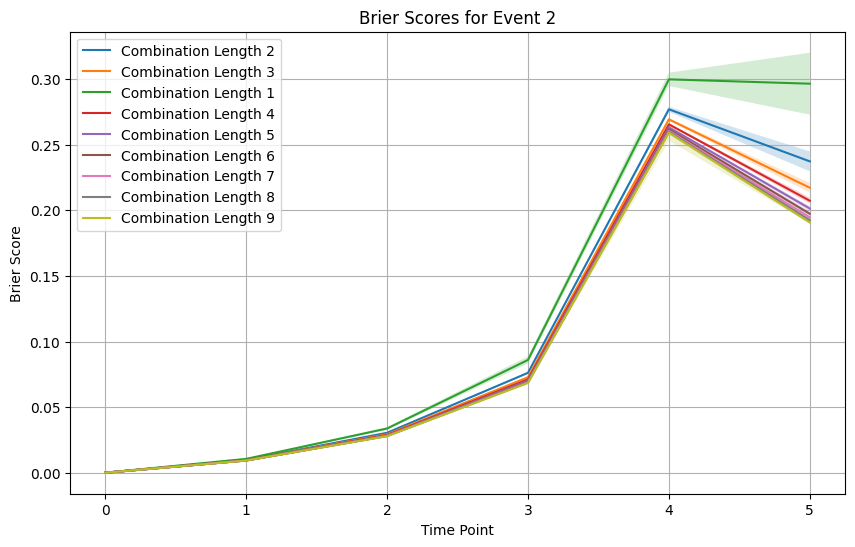

In [7]:
# Calculate statistics
brier_stats_df = calculate_brier_statistics(reshaped_brier_df)

# Plot the Brier scores
plot_brier_scores(brier_stats_df)